# Logistic Regression with a Neural Network Intuition

Build a logistic regression classifier to recognize cats.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

### Overview of the Problem Set

**Problem Statement:**   
We are given a dataset ("data.h5") containing: 
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0) 
- a test set of m_test images labeled as cat or non-cat 
- each image is of shape `(num_px, num_px, 3)` where 3 is for the 3 channels (RGB). Thus, each image is square `(height = num_px)` and `(width = num_px)`.

We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

#### Load dataset

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added *"_orig"* at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with `train_set_x` and `test_set_x` (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your `train_set_x_orig` and `test_set_x_orig` is an array representing an image. We can visualize an example by running the following code.


y = 1 => 'cat' picture


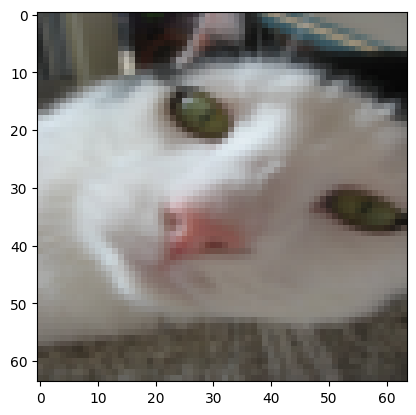

In [34]:
# Example of a picture
index = 14
plt.imshow(train_set_x_orig[index])
print (f"y = {train_set_y[0, index]} => '{classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}' picture")

y = 0 => 'non-cat' picture


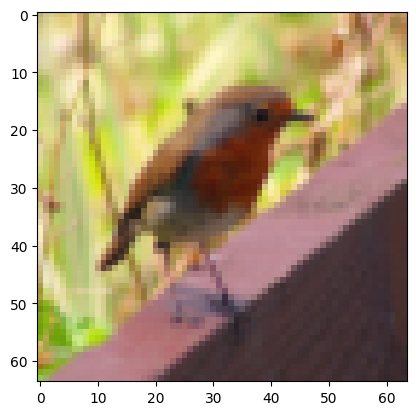

In [25]:
index = 10
plt.imshow(train_set_x_orig[index])
print (f"y = {train_set_y[0, index]} => '{classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}' picture")

#### Pre-process

In [12]:
m_train = train_set_x_orig.shape[0] #number of training examples
m_test =  test_set_x_orig.shape[0]  #number of test examples
num_px = train_set_x_orig.shape[1]  #height = width of a training image

print(f"Number of training examples: m_train = {m_train}")
print(f"Number of testing examples: m_test = {m_test}")
print(f"Height/Width of each image: num_px = {num_px}")
print(f"Each image is of size: ({num_px}, {num_px}, 3)")
print(f"train_set_x shape: {train_set_x_orig.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x shape: {test_set_x_orig.shape}")
print(f"test_set_y shape: {test_set_y.shape}")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we should now reshape images of shape (num_px, num_px, 3) to a numpy-array of shape `(num_px * num_px * 3, 1)`. After this, the training (and test) dataset is a numpy-array where each column represents a *flattened image*. There should be *m_train* (respectively *m_test*) columns.

In [13]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])

In [15]:
print(f"train_set_x_flatten shape: {train_set_x_flatten.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x_flatten shape: {test_set_x_flatten.shape}")
print(f"test_set_y shape: {test_set_y.shape}")
print(f"sanity check after reshaping: {train_set_x_flatten[0:5,0]}")

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and **standardize** your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array.  
But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

#### Standardize

In [26]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255